# Jhavakar Thillainathan DIY Covid-19 Dashboard

This is my DIY Covid Dashboard, which I have coded from developed in the previous notebooks. The dashboard will be displayed using [voila](https://voila.readthedocs.io/en/stable/index.html), a Python dashboarding tool that converts notebooks to standalone dashboards.

In [136]:
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API
from datetime import date
from datetime import datetime

In [137]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [138]:
with open('covid.json', 'rt') as INFILE:    
    data=json.load(INFILE)

## Latest COVID DATA FROM PUBLIC HEALTH ENGLAND

The dashboard contains Date, New Cases, New Admissions and New Deaths

In [139]:
def wrangle_data(data):

    datalist = data['data']
    
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    
    def parse_date(datestring):
    
        return pd.to_datetime(datestring, format="%Y-%m-%d")
                    
    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])
    
    index = pd.date_range(startdate, enddate, freq='D')
    coviddf = pd.DataFrame(index=index, columns=['newCasesByPublishDate', 'newAdmissions', 'newDeaths28DaysByDeathDateRate'])
    
    for entry in datalist: # each entry is a dictionary with date, cases, admissions and deaths
        date = parse_date(entry['date'])
    
        for column in ['newCasesByPublishDate', 'newAdmissions', 'newDeaths28DaysByDeathDateRate']:

            if pd.isna(coviddf.loc[date, column]): 

                value = (entry[column]) if entry[column] != None else 0.0

                coviddf.loc[date, column] = value
                
            
    # fill in any remaining "holes" due to missing dates
    coviddf.fillna(0.0, inplace = True)
    
    return coviddf

In [140]:
coviddf = wrangle_data(data) # df is the dataframe for plotting

In [141]:
#coviddf

In [142]:
coviddf.drop(coviddf.tail(20).index,inplace=True) # drop last 20 rows

In [143]:
# our API access function. This will be called by the button when it is clicked
def access_api():
    
    england = [
    'areaType=nation',
    'areaName=England'
    ]

    
    # values here are the names of the PHE metrics
    newCases = {
    'date': 'date',
    'cases': 'newCasesByPublishDate', 
    'admissions': 'newAdmissions',
    'deaths': 'newDeaths28DaysByDeathDateRate'
    }
    
    api = Cov19API(filters = england, structure = newCases)
    covid = api.get_json()

    return data

In [144]:
def api_button_callback(button):
    def refresh_graph():
        current = scale.value
        if current == scale.options[0]:
            other = scale.options[1]
                
        else:
            other = scale.options[0]
        scale.value = other
        scale.value = current
        
       
    apidata = access_api()
    global coviddf
    coviddf = wrangle_data(apidata)
    refresh_graph()
    apibutton.icon="check"


    today = date.today()
    d1 = today.strftime('%B %D %Y')
    now = datetime.now()
    print ("We are the {:%d, %b %Y}".format(today))
        
    
        
apibutton = wdg.Button(
    description = 'Fetch Data', 
    disabled = False,
    button_style = 'success', 
    tooltip = 'Click to download current Public Health England data',
    
    icon = 'download'
)


apibutton.on_click(api_button_callback) 

display(apibutton)

Button(button_style='success', description='Fetch Data', icon='download', style=ButtonStyle(), tooltip='Click …

# Graphs and Analysis

In [145]:
coviddf.to_pickle("coviddf.pkl") #to create a pickle file

In [146]:
coviddf = pd.read_pickle("coviddf.pkl")

Output()

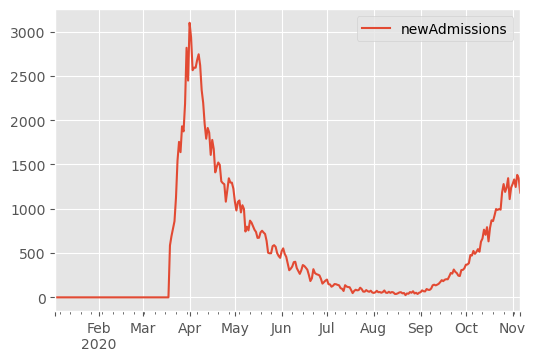

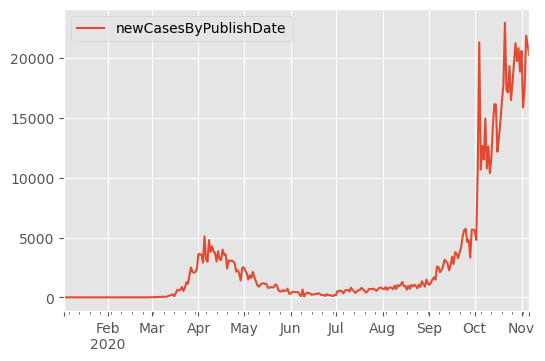

In [147]:
series = wdg.SelectMultiple(
    options = ['newCasesByPublishDate', 'newAdmissions', 'newDeaths28DaysByDeathDateRate'],
    value = ['newCasesByPublishDate', 'newAdmissions', 'newDeaths28DaysByDeathDateRate'],
    rows = 3,
    description = 'Stats:',
    disabled = False
    
)

scale = wdg.RadioButtons(
    options = ['linear', 'log'],
    description = 'Scale:',
    disabled= False
)


controls = wdg.HBox([series, scale])

def covid_graph(gcols, gscale):
    if gscale == 'linear':
        logscale = False
    else:
        logscale = True
    ncols = len(gcols)
    if ncols > 0:
        coviddf[list(gcols)].plot(logy = logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

graph = wdg.interactive_output(covid_graph, {'gcols': series, 'gscale': scale})

coviddf.plot(y='newAdmissions')

coviddf.plot(y='newCasesByPublishDate')

display(controls, graph)

**Author and Copyright Notice** Remember if you deploy this dashboard as a Binder it will be publicly accessible. Take credit for your work! Also acknowledge the data source: *Based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england).*

**(C) 2020 Jhavakar Thillainathan** all rights reserved.